## **Introduction**

As curators of music, DJs often amass vast libraries of songs, sounds, and audio clips over the course of their careers. Over time library management becomes crucial to ensure that a DJ can access their tracks quickly as well as find other related tracks that will mix well with the original one. 

As a DJ, I regularly collect music across many genres to use in music mixes, livestreams, and in person events. Over the years my library has grown to a few thousand tracks. As I continually search for new methods to group tracks together into playlists and 'crates' I try to incorporate techniques of data science to optimize my analysis process. With this in my, the goal of this project is to employ statistical analysis and unsupervised learning techniques to uncover insights about the tracks in my library, discover connections between tracks, and ultimately group them into meaningful categories that will support my longer term focus.

The tracks used come from my Rekordbox DJ software library in the form of an XML file that I parse to collect relevant metadata for each track. Additional metadata for these tracks is then retrieved from Spotify's API.

## **1) Music Collection Analysis**

**Rekordbox Metadata Overview**

Rekordbox exports an XML file of all the songs in a music library as well as some limited metadata The relevant metadata from the Rekordbox includes:  

1) **Track ID:** The unique identifier of each song in Rekordbox library   

2) **Name:** Name of song 

3) **Artist:** Name of primary song creator  

4) **BPM:** Beats Per Minute, the standard measure of a track's tempo. Generally speaking, a track with higher BPM will feel faster than a track with lower BPM.

5) **Key:** The group of pitches, or scale, that forms the basis of a music composition. For simplicity, Rekordbox often converts keys from their standard notation to a more simplified scale using the Camelot system. This scale maps standard key notations to a value between 1A and 12B, including all combinations of digits 1-12 and A-B. This is shown in the below figure.  

6) **Runtime:** The length of the song in seconds  

7) **Genre:**  The genre classification of the track. This is attribute often missing or incorrect in the Rekordbox library tracks and is generally ignored for the purpose of this project since it would defeat the purpose of grouping songs together based on shared characteristics given that this is essentially the definition of genre itself.

8) **Year:** The year the song was released  

**Camelot Key Mapping Wheel**  
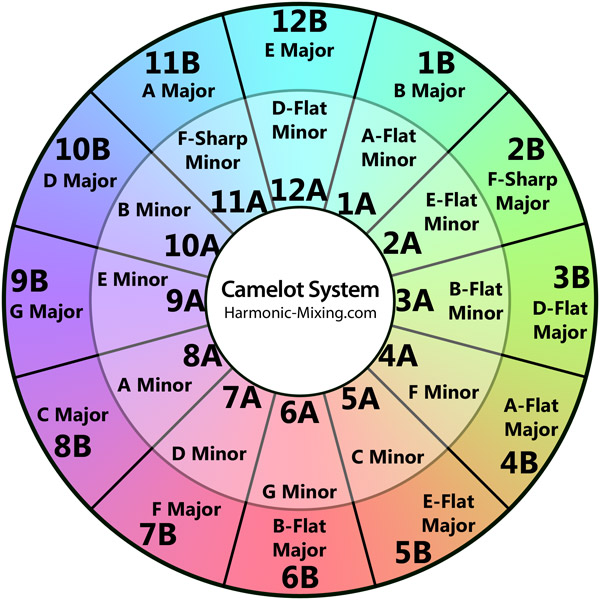  




### **1.1) Music Collection Import**  

**Initial Steps:**  

To get the raw music metadata, I first imported the XML file of music library metadata stored in the Rekordbox DJ software. I then parsed this XML file and stored relevant data as a DataFrame to support further data cleaning and analysis. This included cleaning the dataframe to eliminate many duplicate file inadvertently created over the years as well as standardizing column names and data entries via methods such as value imputation or row removal.

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

# Parse XML file
tree = ET.parse('Library Exports (XML)/collection_7.3.24.xml')

root = tree.getroot()

# Define a list to store data
data = []

# Iterate through each TRACK element in the XML
for track in root.findall('.//TRACK'):
    track_data = {
        'TrackID': track.get('TrackID'),
        'Name': track.get('Name'),
        'Artist': track.get('Artist'),
        'Key': track.get('Tonality'),
        'Runtime': track.get('TotalTime'),
        'Composer': track.get('Composer'),
        'Album': track.get('Album'),
        'Genre': track.get('Genre'),
        'Year': track.get('Year')
        #'Play Count': track.get("PlayCount"),
        #'BitRate': track.get('BitRate'),
        #'DateAdded': track.get('DateAdded')
    }
    
    # Find the TEMPO element within the TRACK
    tempo_element = track.find('.//TEMPO')
    
    # Check if TEMPO element is found
    if tempo_element is not None:
        # Access attributes only if TEMPO is found
        track_data['BPM'] = float(tempo_element.get('Bpm'))
        track_data['Metro'] = tempo_element.get('Metro')
        track_data['Battito'] = int(tempo_element.get('Battito'))
    else:
        # If TEMPO is not found, set default values or handle it as needed
        track_data['BPM'] = None
        track_data['Metro'] = None
        track_data['Battito'] = None
    
    data.append(track_data)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

df = df[['TrackID', 'Name', 'Artist', 'BPM', 'Key', 'Runtime', 'Genre', 'Year']]


In [3]:
# Uncleaned Dataframe including duplicate tracks, unstandardized names, missing values
df.iloc[1020:1030]

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year
1020,20197147,Method Man (Skunk remix) (Dirty Intro DJ Dynam...,Wu-Tang Clan,97.25,10A,207,Hip Hop,1993
1021,6217563,Death (Dirty),Trippie Redd ft DaBaby,82.00,2A,172,Hip Hop,2019
1022,106046607,X Gon' Give It 2 Ya (DJ Dynamite edit) (acapel...,DMX,95.09,2B,165,hip hop x r&b,2003
1023,57139859,What These Bitches Want (Dirty-Beat Junkie Sou...,DMX feat Sisqo,84.00,4A,229,90s x Golden Era,1999
1024,215524440,No Games (Clean Acapella),Serani,94.24,9A,187,Dancehall,2009
1025,223028447,Funkdafied (DJ Club Mix) (Instrumental),Da Brat,91.01,7A,225,90s x Golden Era,1994
1026,139402982,Do It (Instrumental),Mykko Montana feat K-Camp,136.01,11A,223,Hip Hop x R&B,2012
1027,172104737,Bruk It Down (Instrumental),Mr. Vegas,119.00,10B,171,Reggae,2012
1028,258195698,Boasty (Dirty),"Wiley, Stefflon Don & Sean Paul feat Idris Elba",103.00,5B,175,Reggae,2019
1029,179944622,One Blood (Clean),Junior Reid,168.04,4A,239,Reggae,0


In [4]:
len(df)

3681

In [3]:
from pandas import DataFrame
import re

''' 
Finds duplicate files in library based on 
tracks that share the same Name and Artist 
'''
def identify_duplicates(df: DataFrame) -> DataFrame:
    df = df[~df['TrackID'].isna()]
    dup_df = df[df.duplicated(subset = ['Name', 'Artist'], keep='first')]
    return dup_df


''' 
Removes duplicate tracks and unwanted 'ghost' files 
with no metadata from original dataframe
'''
def remove_duplicates(df: DataFrame) -> DataFrame:
    df = df.dropna(subset=['TrackID', 'BPM'])
    duplicates = identify_duplicates(df)
    df_cleaned = df.drop(duplicates.index)
    return df_cleaned


''' 
- Standardizes track names by using regex to remove text within parentheses  
- Standardizing track names to remove additional DJ notation is critical when fetching additional metadata from Spotify,  
otherwise the the API may not recognize the track  
- Do not clean tracks with the (Instrumental) marker, however, as this differentiates the instrumental version of a track from the standard version
'''

def standardize_track_name(df: pd.DataFrame) -> pd.DataFrame:
    def clean_name(name):
        if '(Instrumental)' in name:
            return name
        return re.sub(r'\s*\([^)]*\)', '', name)
    
    df['Name'] = df['Name'].apply(clean_name)
    return df



In [82]:
df_v1 = remove_duplicates(df)

# Cleaned dataframe after duplicate removal / handling missing values in relevant columns
df_v1.iloc[1020:1030]


,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year
1105,261731391,Ice Me Out (Dirty-Cyberkid Intro/Outro),Kash Doll,75.00,9A,193,Trap,2018
1106,143132557,Where I'm From,Digable Planets,98.25,4B,268,Hip Hop,1993
1107,57065216,Ms. New Booty feat. Ying Yang Twins (DJ Organi...,Bubba Sparxxx,97.00,12A,270,hip hop x r&b,2006
1108,90098842,Salt Shaker (CLEAN Intro),Ying Yang Twins,102.06,2A,267,hip hop x r&b,2002
1109,10239911,Get Your Freak On (Dirty Intro),Missy Elliott,88.00,4A,185,Hip Hop,2011
1110,165170375,Back That Ass Up feat. Mannie Fresh & Lil' Way...,Juvenile,95.80,6A,280,hip hop x r&b,1998
1111,169581582,Izzo (H.O.V.A.) (Dirty),Jay-Z,87.00,2B,238,Hip Hop,2001
1112,64047844,Blame It (Instrumental),Jamie Foxx ft T-Pain,88.00,8B,280,R&B,2008
1113,223640683,100 Bands (Dirty),"Mustard ft Quavo, 21 Savage, YG & Meek Mill",93.00,12A,179,Hip Hop,2019
1114,159971611,After Hours (Clean),The Weeknd,109.00,5A,362,Pop,2020


In [12]:
df_v1 = standardize_track_name(df_v1)

# Dataframe after additional cleaning to remove additional DJ notation (e.g. 'Dirty' or 'Instrumental' marker on track)
# Note that 'Blame It (Instrumental)' remains unedited as expected 
df_v1.iloc[1020:1030]

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year
1105,261731391,Ice Me Out,Kash Doll,75.00,9A,193,Trap,2018
1106,143132557,Where I'm From,Digable Planets,98.25,4B,268,Hip Hop,1993
1107,57065216,Ms. New Booty feat. Ying Yang Twins,Bubba Sparxxx,97.00,12A,270,hip hop x r&b,2006
1108,90098842,Salt Shaker,Ying Yang Twins,102.06,2A,267,hip hop x r&b,2002
1109,10239911,Get Your Freak On,Missy Elliott,88.00,4A,185,Hip Hop,2011
1110,165170375,Back That Ass Up feat. Mannie Fresh & Lil' Wayne,Juvenile,95.80,6A,280,hip hop x r&b,1998
1111,169581582,Izzo,Jay-Z,87.00,2B,238,Hip Hop,2001
1112,64047844,Blame It (Instrumental),Jamie Foxx ft T-Pain,88.00,8B,280,R&B,2008
1113,223640683,100 Bands,"Mustard ft Quavo, 21 Savage, YG & Meek Mill",93.00,12A,179,Hip Hop,2019
1114,159971611,After Hours,The Weeknd,109.00,5A,362,Pop,2020


### **1.2) Initial Exploratory Data Analysis**  

After importing and cleaning the initial data, we will conduct EDA to reveal any interesting insights which may be leveraged for further analysis. 

**Correlation Matrix:**  
We use a correlation heatmap to examine the relationship between the relevant attributes. This provides some intuition about the features' relationship with each other and reveal any possible correlation. As shown in the heatmap below, there is a mildly negative relationship between Year and Runtime. This means that, generally speaking, more modern tracks tend to have a shorter runtime than older ones. Most music enthusiasts who listen to songs across a wide range of eras have probably seen this trend. 

Older Disco tracks, for example, often had intros and outros, multiple choruses and verses, and extended bridges / breaks that could result in a 6+ minute track time. In comparison, the runtime of Pop, R&B, and Hip Hop music of today often hovers around 3 minutes maximum; however, while there is a clear downward trend in average track runtime over time (with the exception of the 60s which only includes 5 known tracks), is it only on the scale of a minute or so difference. There are also a large number of tracks that have no year assigned for which the average run time is nearly 8 minutes. 

Overall, this analysis gives a good sense of the types of tracks in my library and can enable me to pursue DJ interests according to the bulk of my library makeup. I may opt to focus more on creating mixes and pursuing gigs for events where the audience prefers modern music and some throwbacks from the 90s / early 2000s. However, I may shy away from events for Gen X / Baby Boomers who may want to hear mostly pre-90s music. 

I can also better estimate the number of tracks to add to a given setlist that I am preparing for a DJ event based on the average runtime. If I am DJing a party that calls for newer music, I may want to add more tracks to my setlist than a party that focuses on oldies and throwbacks. Given that these older tracks have  longer runtimes on average, I may not need as many to get through the same length set as I would for a party for Gen Z, for instance.

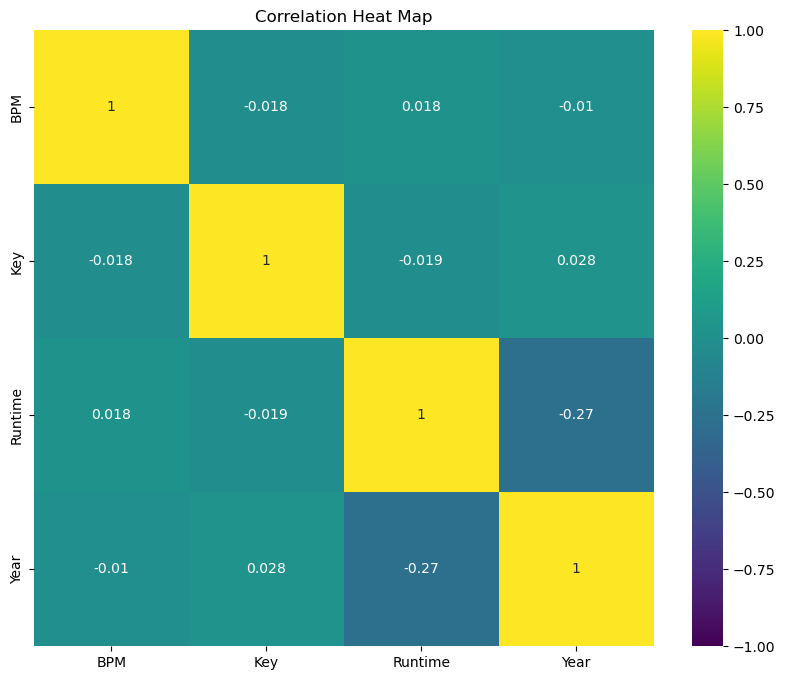

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df_v2 = df_v1.copy()

# Convert 'Key' to categorical values using Label Encoding
df_v2['Key'] = df_v2['Key'].astype('category').cat.codes

# Calculate the correlation matrix
correlation_matrix = df_v2[['BPM', 'Key', 'Runtime', 'Year']].corr()

# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Heat Map')
plt.show()

In [14]:
df_v2['Runtime'] = pd.to_numeric(df_v1['Runtime'], errors='coerce', downcast='integer')

print(f'Total Tracks in Library: {len(df_v2)}')
print(f'Average Track Runtime: {df_v2["Runtime"].mean() / 60:.1f} minutes')


Total Tracks in Library: 2717
Average Track Runtime: 4.6 minutes


**Year Bucketing**

Additionally, bucketing years into Decades will help to automatically group certain tracks together for further analysis

In [18]:
# Convert 'Year' column to integers

# Convert Year column values to integers
df_v2['Year'] = pd.to_numeric(df_v2['Year'], errors='coerce', downcast='integer')

# Bucket years into Decade eras to create additional column
def get_decade(year):
    if 1960 <= year < 1970:
        return '1960s'
    elif 1970 <= year < 1980:
        return '1970s'
    elif 1980 <= year < 1990:
        return '1980s'
    elif 1990 <= year < 2000:
        return '1990s'
    elif 2000 <= year < 2010:
        return '2000s'
    elif 2010 <= year < 2020:
        return '2010s'
    elif 2020 <= year < 2030:
        return '2020s'
    else:
        return 'Unknown'

df_v2['Decade'] = df_v2['Year'].apply(get_decade)

df_v2.sort_values('Decade', ascending = True)

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade
1389,113722927,I FEEL GOOD,JAMES BROWN,147.99,19,163,Funk x Disco,1965,1960s
158,244988217,AIN'T NO MOUNTAIN HIGH ENOUGH,MARVIN GAYE FT. TAMMI TERRELL + DFP,129.00,15,281,Soul x Boogie x Jazz,1967,1960s
104,249074076,I Want You Back,Jackson 5,98.00,14,169,Pop,1969,1960s
1390,126016332,Say it Loud. I'm Black and I'm Proud,James Brown,114.00,11,223,Funk x Disco,1969,1960s
597,124958186,Give It Up,Kool & The Gang,101.58,19,301,Funk,1969,1960s
...,...,...,...,...,...,...,...,...,...
1872,158147363,Backseat Freestyle,Kendrick Lamar,77.00,20,212,Hip Hop,0,Unknown
1873,181791729,Hannah Montana,Migos,135.98,23,211,Hip Hop,0,Unknown
1874,22488796,BackSeat Freestyle,Kendrick Lamar,77.01,13,225,Hip Hop,0,Unknown
1838,154944214,Monster,Future,133.00,5,220,Hip Hop,0,Unknown


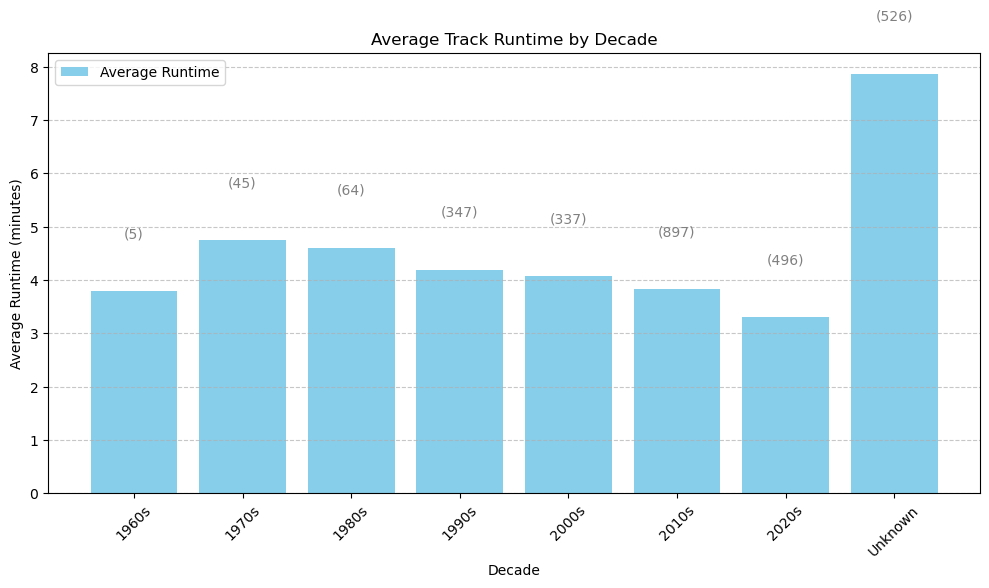

In [19]:
# Group rows by 'Decade' and calculate average runtime in minutes
average_runtimes = df_v2.groupby('Decade')['Runtime'].mean()/60

# Find number of tracks by decade
track_counts = df_v2['Decade'].value_counts()

# Plot average run time and count of tracks by decade
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(average_runtimes.index, average_runtimes.values, color='skyblue', label='Average Runtime')
for i, decade in enumerate(average_runtimes.index):
    ax.text(i, average_runtimes[decade] + 1, f'({track_counts[decade]})', ha='center', color='gray')

# Formatting
ax.set_xlabel('Decade')
ax.set_ylabel('Average Runtime (minutes)')
plt.title('Average Track Runtime by Decade')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.show()

### **1.3) Initial Clustering (K-Means)**  

Next we conduct K-Means clustering to group  tracks into clusters according to relevant attributes. This is a useful exercise to determine if there are other methods to group tracks together aside from by genre, which is the default method of grouping many songs in most music platforms. The following attributes will be used to cluster the data: BPM, Key, Runtime, and Decade (in place of the Year attribute).

**Finding optimal number of clusters**  
To determine the optimal number of clusters for grouping the tracks, we will employ the elbow method. This method plots the within-cluster sum of squares (WCSS) against the number of clusters. WCSS measures total variance within each cluster, with lower values indicating that clusters are more compact. As K grows, the clusters become more compact and WCSS falls. When the rate of this decrease in WCSS begins to level out, the algorithm has ideally found the optimal balance between the number of clusters and cluster compactness. 

Looking at the plot below, the rate of decrease begins to flatten at about k=2 clusters; however, this would not make for a very interesting track grouping, and so we will try k=4 clusters instead, which still seems like a fair choice given that the slope begins to decrease faster for K >4. For this cluster grouping, we will filter out data where the Decade (and consequently Year) value is Unknown as this represents a relatively large portion of the data and may skew results.

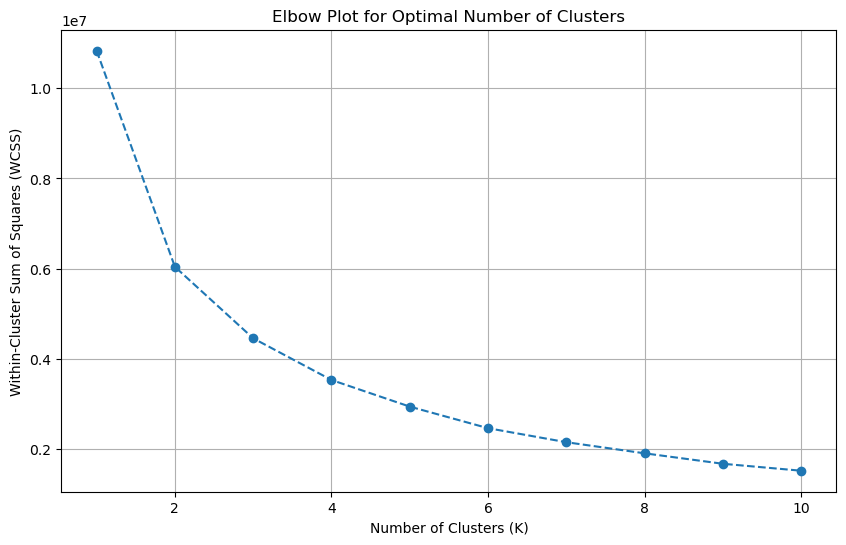

In [20]:
from sklearn.cluster import KMeans

df_v3 = df_v2.copy()

# Filter out rows with 'Unknown' decade
df_v3 = df_v3[df_v3['Decade'] != 'Unknown']

# Convert 'Decade' to numerical values if it's not already
df_v3['Decade'] = df_v3['Decade'].apply(lambda x: int(x[:4]) if x != 'Unknown' else 0)

# Select relevant features for clustering
features = ['BPM', 'Key', 'Runtime', 'Decade']
X = df_v3[features].dropna()  # Drop rows with NaN values in the selected features

# Determine the optimal number of clusters using the elbow method
wcss = []
K_range = range(1, 11)

for K in K_range:
    kmeans = KMeans(n_clusters=K, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

**Remarks:**  
In order to improve the clustering outcome, we will standardize the data and encode columns which should be categorical using the StandardScaler and OneHotEncoder functions in combination with the Pipeline function from Sci-Kit Learn.

Interestingly, most of the tracks from cluster 0 appear to be from the 1990s, while many tracks from cluster 2 are actually multi-track mixes that I have recorded myself (as evidenced by the Runtimes which are much higher than the standard runtime of any one track). Cluster 2 tracks also seem to generally reflect those tracks that do not have a specific Year of release designated. 

In contrast, data points in cluster 4 seem to consist of those tracks from the 2020s. Clearly the Year attribute seems to have a larger impact on the clustering, especially when compared with some of the other attributes. To better group tracks using addtional data, we will leverage Spotify to gather additional metadata.

In [21]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the features for clustering
features = ['BPM', 'Key', 'Runtime', 'Decade']

# Separate the features and target
X = df_v2[features]

# One-hot encode the 'Decade' column
column_transformer = ColumnTransformer(
    transformers=[
        ('decade', OneHotEncoder(), ['Decade'])
    ],
    remainder='passthrough'
)

# Standardize the data
scaler = StandardScaler()

# Create a pipeline to handle encoding and scaling
pipeline = Pipeline(steps=[
    ('transformer', column_transformer),
    ('scaler', scaler)
])

# Transform the features
X_transformed = pipeline.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)  
clusters = kmeans.fit_predict(X_transformed)

df_v3 = df_v2.copy()

# Add the cluster label column to df_v3
df_v3['Cluster'] = clusters


/Users/fjohnson35/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**Cluster 0 Tracks**

In [23]:
df_v3[df_v3['Cluster']==0].head(15) 

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Cluster
29,11369466,Can't Take My Eyes Off Of You,Lauryn Hill,89.00,6,221,R&B,1998,1990s,0
31,262725364,Candy Rain,Soul for Real,141.22,1,276,,1994,1990s,0
35,202761241,I'm So Into You,SWV,99.01,15,278,R&B,1993,1990s,0
42,85346502,This Is How We Do It,Montell Jordan,104.00,13,223,Hip Hop,1995,1990s,0
46,42321449,Hip Hop Hooray,Naughty By Nature,99.37,5,335,Blends x Mash Ups x Party Breaks,1993,1990s,0
48,168990980,Real Love,Mary J. Blige,95.00,22,270,R&B,1992,1990s,0
52,54511723,"Right Here, Human Nature [Beat Junkie Sound Ed...",S.W.V.,94.00,21,184,,1993,1990s,0
54,254699334,SHOOP,SALT N PEPA,96.93,22,241,90s x Golden Era,1993,1990s,0
55,27739,If You Love Me,Brownstone,95.16,2,222,R&B / Rap,1994,1990s,0
57,54508147,Kiss of Life,Sade,97.08,3,250,,1992,1990s,0


**Cluster 1 Tracks**


In [24]:
df_v3[df_v3['Cluster']==1].head(15)

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Cluster
23,1356108,Happy,Pharrell Williams,170.00,15,262,R&B,2014,2010s,1
24,189848022,Saturday Love,Cherrelle & Alexander O'Neal,115.00,9,353,Funk x Disco,1985,1980s,1
25,160217753,I Wanna Be Your Lover,Prince,116.00,7,341,R&B,1979,1970s,1
26,91323844,Brown Skin Girl,Beyonce feat Saint JHN WizKid & Blue Ivy Carter,92.00,10,222,Hip Hop x R&B,2019,2010s,1
27,193146384,Teach Me How To Dougie,California Swag District,85.00,18,260,Hip Hop,2010,2010s,1
28,267039839,Human Nature,Michael Jackson,93.00,4,245,Pop,1982,1980s,1
30,221191923,CRUISIN,SMOKEY ROBINSON,174.00,6,281,,1979,1970s,1
32,232679726,Love Come Down,Evelyn Champagne King,116.00,9,373,R&B,1982,1980s,1
34,176420394,Outstanding Intro/Outro,Gap Band,98.60,12,354,,1982,1980s,1
36,162516604,We Are Family,Sister Sledge,117.00,21,229,Disco,1979,1970s,1


**Cluster 2 Tracks**


In [26]:
df_v3[df_v3['Cluster']==2].head(15)

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Cluster
4,223697707,Demo Track 1,Loopmasters,128.00,0,172,,0,Unknown,2
5,131195771,Demo Track 2,Loopmasters,120.00,0,128,,0,Unknown,2
33,245754931,Rock With You,Michael Jackson,115.01,11,171,R&B,0,Unknown,2
47,169785633,Rock Wit U,Ashanti,94.98,22,214,R&B,0,Unknown,2
65,320889,Return Of The Mack,Mark Morrison,97.00,21,225,90's R&B,0,Unknown,2
76,85747275,Lovely Day,Unknown Artist,100.16,0,2758,,0,Unknown,2
80,45989018,Repititions,Unknown Artist,100.52,1,1560,,0,Unknown,2
96,10131708,Warm Up,Unknown Artist,93.01,3,1989,,0,Unknown,2
106,160340740,Sir Duke,Stevie Wonder,103.00,7,205,,0,Unknown,2
110,71083299,Best Of My Love,Emotions,116.01,22,217,R&B,0,Unknown,2


**Cluster 3 Tracks**


In [28]:
df_v3[df_v3['Cluster']==3].head(15)

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Cluster
117,115897473,Essence,WizKid,104.00,23,249,,2020,2020s,3
134,233098188,Break My Soul,Beyonce,115.00,7,283,Pop,2022,2020s,3
173,111248765,Can't Stop Won't Stop,King Combs & Kodak Black,97.00,2,178,Hip Hop,2022,2020s,3
175,234859493,Jane,Skip Marley,109.00,15,234,Afrobeat,2023,2020s,3
190,264463929,Free Mind,Tems,94.56,7,247,Alte,2020,2020s,3
195,160804294,Slow Down,Skip Marley & H.E.R. feat Wale,100.00,3,225,Hip Hop x R&B,2020,2020s,3
199,266055539,Smile,WizKid,90.00,1,251,Reggae,2020,2020s,3
208,211285190,West Coast Weekend,"Tyga, YG & Blxst",107.00,2,199,Hip Hop,2023,2020s,3
209,77689736,I Need A Thug,City Girls,102.00,20,117,Hip Hop,2023,2020s,3
213,93985471,Chad,Isaiah Rashad,127.00,1,159,,2021,2020s,3


### **2) Getting Additional Track Metadata via Spotify**

Gathering additional data on the songs in my music library will allow me cluster the data in more ways that ideally provide more flexibility and insights. 

Using Spotify's API, we can retrieve additional attributes for each track and use them to analyze the data further. 



**Note on Resources Used:**   

This section deals almost entirely with accessing the Spotify API and is a direct implementation of the following tutorial from @TechWithTim:

- [How to Use Spotify's API with Python](https://www.youtube.com/watch?v=WAmEZBEeNmg&ab_channel=AkamaiDeveloper)

Additionally, this portion of the project utilized many concepts covered in the Data Science for DJing Medium article by James Camagong:


- [Data Science for DJing](https://medium.com/swlh/data-science-for-djing-b4c7a422c197)

**Note on Data Retrieval Processing Time:**   

- Analyzing 2700 tracks from my library and fetching relevant data in the Spotify API takes 15+ minutes when running the applicable Python function.     

- To avoid the need to rerun this function to get the data, a CSV file of the data named _df_spotified_v1.csv_ is provided with all the Spotify data prepoluated.


**Additional Track Attributes to Retrieve from Spotify:**

- **Danceability:** Describes how suitable a track is for dancing based on a combination of musical elements including tempo (AKA Beats Per Minute / BPM), rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.  

- **Energy:** Is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.    

- **Loudness:** The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.  

- **Speechiness:** Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.  

- **Acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.  

- **Instrumentalness:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.  

- **Liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **Valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

### **2.1) Setting up Spotify API Access**

In [29]:
from dotenv import load_dotenv
import os
import base64
from requests import post, get
import json


#Establishing environment to hold client_id/secret to access API
load_dotenv()

client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')


# Function to retrieve Spotify token
def get_token():
    auth_string = client_id + ':' + client_secret
    auth_bytes = auth_string.encode('utf-8')
    auth_base64 = str(base64.b64encode(auth_bytes), 'utf-8')

    url = 'https://accounts.spotify.com/api/token'
    headers = {
        'Authorization': 'Basic ' + auth_base64,
        'Content-Type': 'application/x-www-form-urlencoded'
    }
    data = {'grant_type': 'client_credentials'}
    result = post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result['access_token']
    return token

# Function to get Authorization header
def get_auth_header(token):
    return {'Authorization': 'Bearer ' + token}

### **2.2) Defining Relevant API Functions**

In [32]:
'''
Given the API token, name of a track, and name of corresponding artist, will find the track in the Spotify database
'''

def search_for_track(token, track_name, artist_name):
    url = 'https://api.spotify.com/v1/search'
    headers = get_auth_header(token)
    query = f'q=track:{track_name} artist:{artist_name}&type=track&limit=1'

    query_url = url + '?' + query
    result = get(query_url, headers=headers)

    if result.status_code == 200:
        json_result = result.json()
        if 'tracks' in json_result and 'items' in json_result['tracks']:
            tracks = json_result['tracks']['items']
            if len(tracks) > 0:
                return tracks[0]  # Return the first track found
            else:
                print('No track with this name and artist exists.')
                return None
        else:
            print('Unexpected response format from Spotify API.')
            return None
    else:
        print(f"Error searching for track: {result.status_code}")
        return None


In [33]:
'''
Given the API token and track id, gets relevant attributes of track
'''

def get_track_attributes(token, track_id):
    url = f'https://api.spotify.com/v1/audio-features/{track_id}'
    headers = get_auth_header(token)

    result = get(url, headers=headers)

    if result.status_code == 200:
        json_result = result.json()
        return json_result
    else:
        print(f"Error fetching track attributes: {result.status_code}")
        return None


In [34]:
'''
Leverages previous functions to take in a dataframe of songs, get additional spotify attributes via the API,
and add them to an updated version of the dataframe
'''

def add_spotify_attributes(df):
    token = get_token()  # Get the Spotify API token
    
    # Initialize lists to store Spotify attributes
    danceability_list = []
    energy_list = []
    acousticness_list = []
    instrumentalness_list = []
    liveness_list = []
    valence_list = []
    loudness_list = []
    speechiness_list = []
    
    # For each row (AKA track) in the dataframe...
    for index, row in df.iterrows():

        # Track percentage completion
        percentage_complete = (index + 1) / len(df) * 100
        print(f'Progress: {percentage_complete:.2f}%')


        track_name = row['Name']
        artist_name = row['Artist']
        
        # Search for the track in Spotify's database
        track_info = search_for_track(token, track_name, artist_name)

        if track_info:
            track_id = track_info['id']
            print(f"Track found: {track_info['name']} by {track_info['artists'][0]['name']}")

            # If the track is found, get all attributes
            attributes = get_track_attributes(token, track_id)

            # Extract only the relevant attributes as listed previously 
            if attributes:
                # Extract desired attributes and append to lists
                danceability_list.append(attributes['danceability'])
                energy_list.append(attributes['energy'])
                acousticness_list.append(attributes['acousticness'])
                instrumentalness_list.append(attributes['instrumentalness'])
                liveness_list.append(attributes['liveness'])
                valence_list.append(attributes['valence'])
                loudness_list.append(attributes['loudness'])
                speechiness_list.append(attributes['speechiness'])
            else:
                print(f"Error fetching attributes for {track_name} by {artist_name}. Skipping.")
                # Append None or handle error as per your needs
                danceability_list.append(None)
                energy_list.append(None)
                acousticness_list.append(None)
                instrumentalness_list.append(None)
                liveness_list.append(None)
                valence_list.append(None)
                loudness_list.append(None)
                speechiness_list.append(None)
        else:
            print(f"Track {track_name} by {artist_name} not found. Skipping.")
            # Append None or handle error as per your needs
            danceability_list.append(None)
            energy_list.append(None)
            acousticness_list.append(None)
            instrumentalness_list.append(None)
            liveness_list.append(None)
            valence_list.append(None)
            loudness_list.append(None)
            speechiness_list.append(None)

    # Add the attributes to dataframe 
    df['Danceability'] = danceability_list
    df['Energy'] = energy_list
    df['Acousticness'] = acousticness_list
    df['Instrumentalness'] = instrumentalness_list
    df['Liveness'] = liveness_list
    df['Valence'] = valence_list
    df['Loudness'] = loudness_list
    df['Speechiness'] = speechiness_list

    # Save dataframe as local CSV file to avoid having to rerun this function multiple times (it takes ~15-17 minutes to run)
    output_file_path= '/Users/fjohnson35/Library/Mobile Documents/com~apple~CloudDocs/Data Science/DJ/Library Analysis/df_spotified_v1.csv'
    df.to_csv(output_file_path, index=False)
    
    return df


### **2.3) Getting Spotify Data**

In [ ]:
#df_spotified_v1 = add_spotify_attributes(df_v2)


**Loading CSV File Without USING SPOTIFY API**  
Run below function to import Spotified csv rather than trying to reaccess data (update path to match local CSV storage location):

In [35]:
file_path = "/Users/fjohnson35/Library/Mobile Documents/com~apple~CloudDocs/Data Science/DJ/Library Analysis/df_spotified_v1.csv"

df_spotified_v1 = pd.read_csv(file_path)

In [36]:
# Removing tracks where Spotify Attributes not present. 
# Using Loudness since every track with Spotify data should have a value here
df_spotified_v1 = df_spotified_v1[~df_spotified_v1['Loudness'].isna()]

print(f'Total Tracks Found in Spotify: {len(df_spotified_v1)}')
df_spotified_v1

Total Tracks Found in Spotify: 1543


,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Danceability,Energy,Acousticness,Instrumentalness,Liveness,Valence,Loudness,Speechiness
2,1356108,Happy,Pharrell Williams,170.00,15,262,R&B,2014,2010s,0.647,0.822,0.21900,0.000000,0.0908,0.962,-4.662,0.1830
3,189848022,Saturday Love,Cherrelle & Alexander O'Neal,115.00,9,353,Funk x Disco,1985,1980s,0.782,0.477,0.10400,0.000138,0.0629,0.414,-14.220,0.0623
4,160217753,I Wanna Be Your Lover,Prince,116.00,7,341,R&B,1979,1970s,0.812,0.506,0.03990,0.084700,0.0671,0.727,-8.825,0.0453
7,267039839,Human Nature,Michael Jackson,93.00,4,245,Pop,1982,1980s,0.628,0.409,0.49800,0.005650,0.2900,0.755,-14.348,0.0306
8,11369466,Can't Take My Eyes Off Of You,Lauryn Hill,89.00,6,221,R&B,1998,1990s,0.747,0.662,0.01180,0.000000,0.1380,0.630,-7.900,0.0796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2706,218786048,ATTITUDE,Don Toliver,155.00,3,161,NaN,2024,2020s,0.650,0.655,0.02850,0.000000,0.1590,0.432,-5.430,0.0385
2707,98214588,BANDIT,Don Toliver,130.00,19,147,NaN,2024,2020s,0.686,0.733,0.00567,0.000000,0.2460,0.141,-5.268,0.0576
2708,31917569,Hot One,Denzel Curry,81.50,11,165,NaN,2024,2020s,0.766,0.724,0.71700,0.000000,0.1500,0.827,-5.145,0.1800
2709,266231832,Black&Blue,Vince Staples,137.99,5,198,NaN,2024,2020s,0.527,0.270,0.70700,0.000000,0.1020,0.230,-10.855,0.0380


**Remarks**  

Note that not all of the original library tracks were found in the spotify API. After removing tracks from the dataframe that could not be located in Spotify, the full dataframe contains 1,543 tracks (as opposed to the orginal 2,717). This is still plenty of data to conduct further analysis on, however. It is also worth noting that without standardizing the track names in the beginning, only 400 or so tracks can be located in Spotify. So initial data cleaning steps allowed us to located over 1000 more tracks. 

## **3) Exploratory Data Analysis with Additional Spotify Attributes**

Now that we have our Spotify augmented library, we will proceed with the more EDA using these attributes. 

### **3.1) Full Feature Correlation Matrix**

**Correlation Matrix**  

First we build a correlation matrix to understand if any of the features may be redundant or impact further analysis such as clustering in any way. This time we use all of the Spotify features as well as the Decades calculated column. 

From this, we see that there is some level of positive correlation between loudness and energy (0.6). Since we need to deal with correlated features to ensure the best outcome of later clustering techniques, we will remove Loudness, which is not an especially useful feature for a DJ to know given that one can easily adjust the gain / volume of a track. Energy is the more interesing attribute of the two and will remain. 

There is also a slightly negative correlation between Acousticness and Energy (-0.32), but this is negligible enough that both attributes can be retained. 

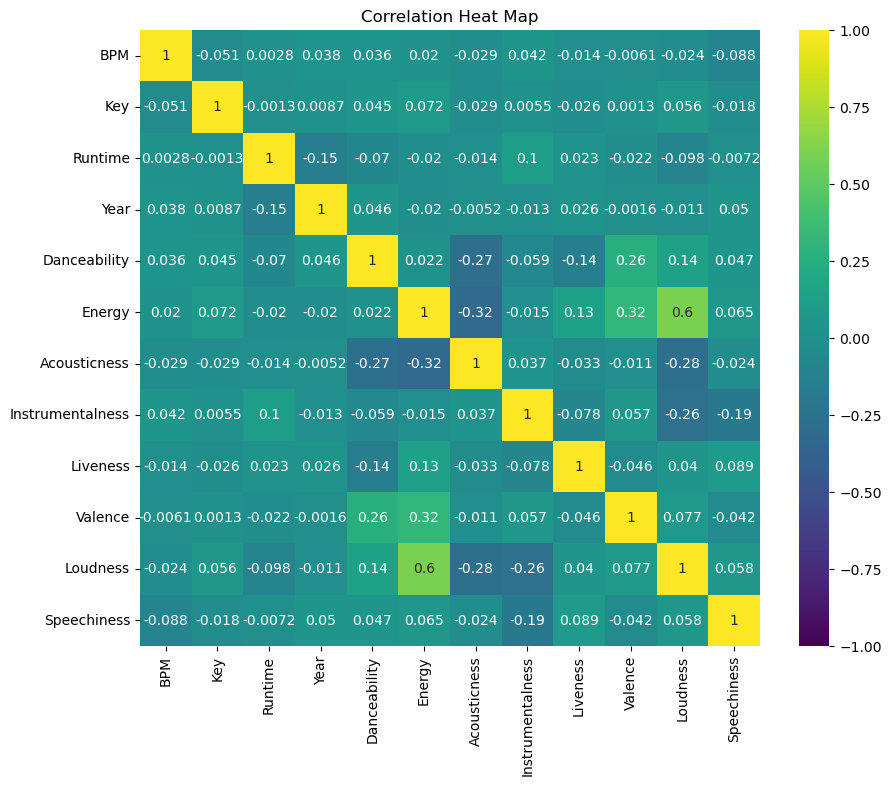

In [38]:
# Convert Decades to categorical variable
df_spotified_v1['Decade'] = pd.Categorical(df_spotified_v1['Decade'])

# Calculate the correlation matrix
correlation_matrix_spotified = df_spotified_v1[['BPM', 'Key', 'Runtime', 'Year',
       'Danceability', 'Energy', 'Acousticness', 'Instrumentalness',
       'Liveness', 'Valence', 'Loudness', 'Speechiness']].corr()

# Plot the heat map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_spotified, annot=True, cmap='viridis', vmin=-1, vmax=1)
plt.title('Correlation Heat Map')
plt.show()

In [39]:
# Remove Loudness column
df_spotified_v2 = df_spotified_v1.drop(columns=['Loudness'])


### **3.2) Data Distribution by Features**

**Feature Distributions**  

We next plot the distributions of relevant features to see the spread of the data along these attributes. Year is not plotted since it is accounted for in reviewing track distributions across the Decades in the previous Exploratory Data Analysis section.

_Note:_ Instrumentalness plot displayed separately to optimize visual scaling.

The distribution plots reveal a few interesting insights. A large portion of the tracks hover around the 100 BPM range, and Keys are somewhat uniformly distributed across all tracks. Track runtime clearly follows a normal distribution with an average value of around 4 minutes, but a standard deviation of over 2 minutes. My personal DJ mixes within the library than can run up to an hour long certainly impact this number as each mix includes multiple tracks that are spliced together sequentially. Removing them from the analysis would certainly lower these statistics for runtime. 

Additionally, according to Spotify statistics tracks tend to be more danceable, medium energy, low in acoustic instrumentation, and generally are not performed in front of a live audience. Speechiness is also relatively low across most tracks; however, virtually all tracks have low instrumentalness. These two features seem to directly contradict each other, as one would expect low speechiness tracks to have high instrumentalness and vice versa. The fact that both attributes are low seems to point to a potential inaccuracy in the way Spotify measures and/or defines these metrics.  



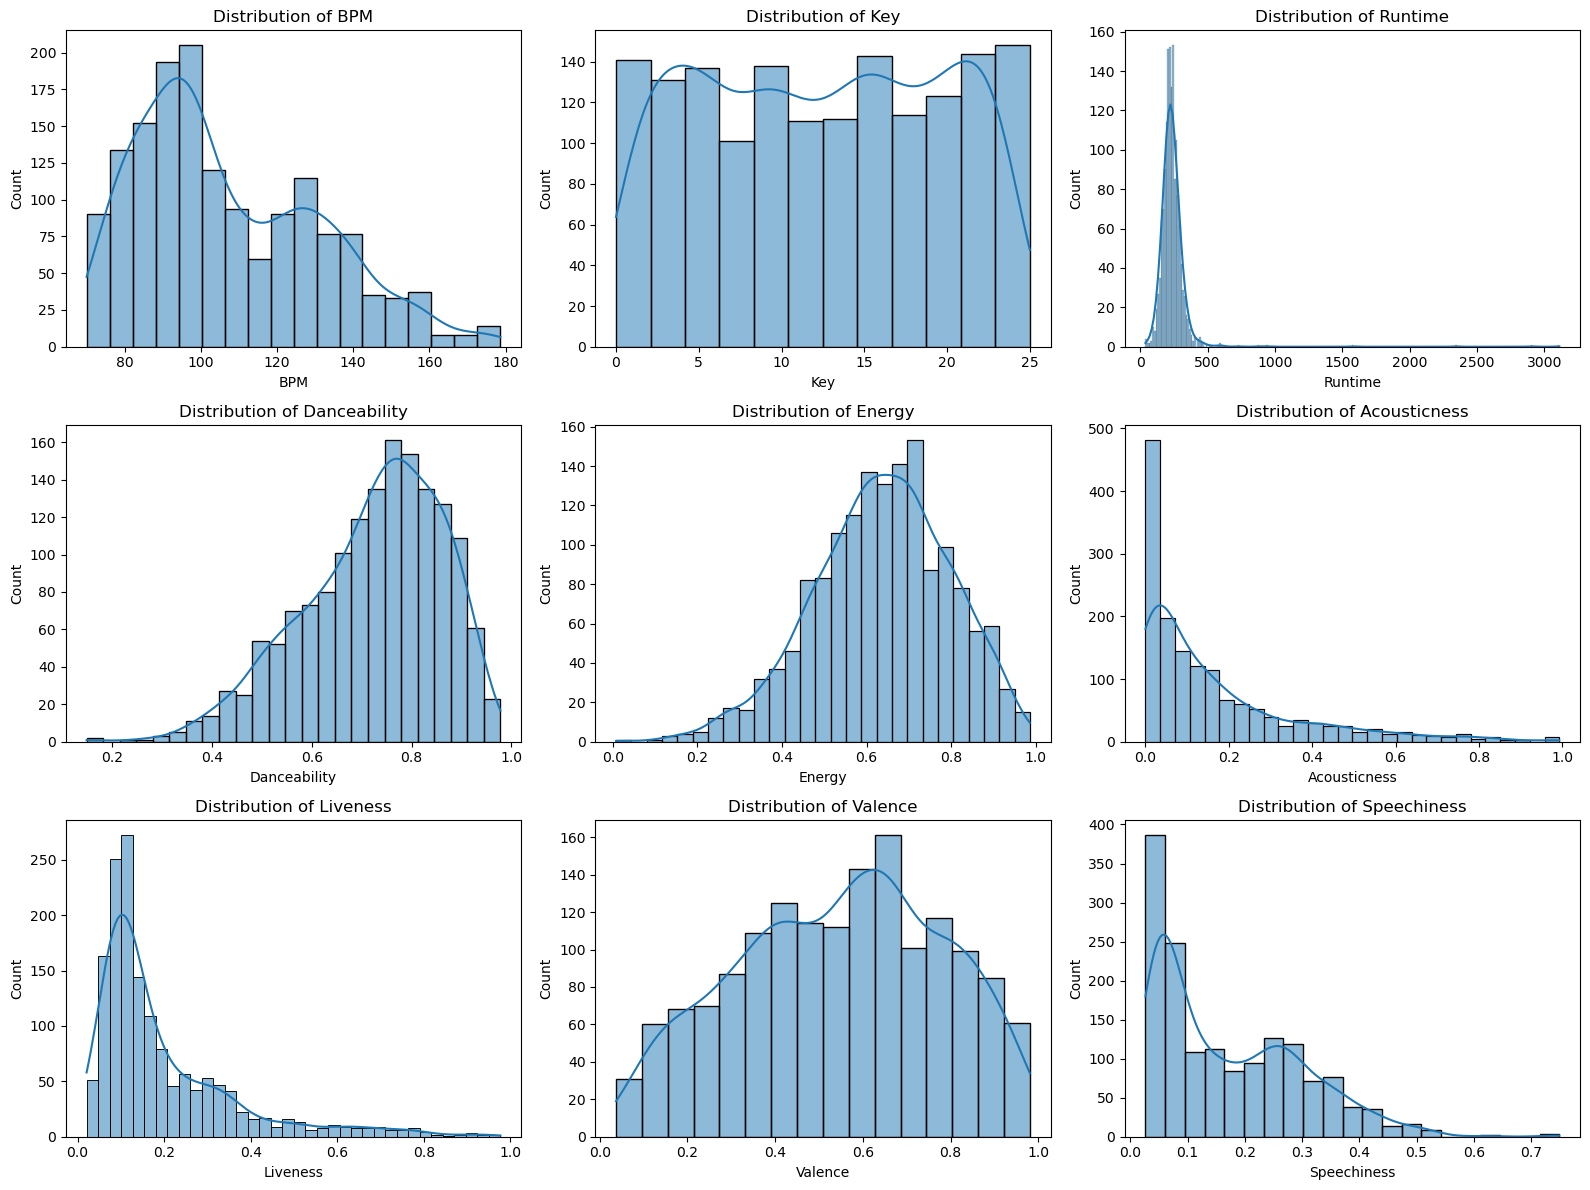

In [40]:
# Features to plot
features = ['BPM', 'Key', 'Runtime', 'Danceability', 'Energy',
            'Acousticness', 'Liveness', 'Valence', 'Speechiness']

# Create figure / axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 12))
axes = axes.flatten()

# Plot each feature distributions 
for i, feature in enumerate(features):
    sns.histplot(df_spotified_v1[feature], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [41]:
mean_runtime = df_spotified_v1['Runtime'].mean() / 60  
std_runtime = df_spotified_v1['Runtime'].std() / 60   

print(f'Mean Track Duration: {mean_runtime:.2f} minutes')
print(f'Standard Deviation of Track Duration: {std_runtime:.2f} minutes')

Mean Track Duration: 3.97 minutes
Standard Deviation of Track Duration: 2.29 minutes


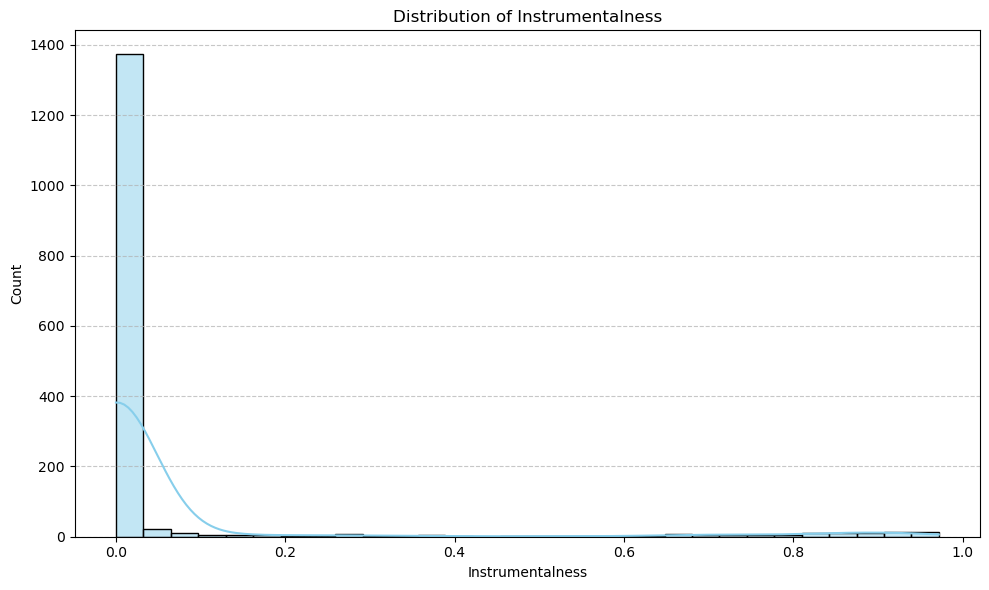

In [42]:
# Separate Plot of Instrumentalness
plt.figure(figsize=(10, 6))
sns.histplot(df_spotified_v1['Instrumentalness'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Instrumentalness')
plt.xlabel('Instrumentalness')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **4) Full Feature Clustering**

Now that we have additional Spotify data, we will once again cluster the data, now using these added attributes.

### **4.1) K-Means Clustering**

**Elbow Method**  
Again, we use the Elbow method to decide the optimal number of clusters for K-Means clustering. Again the optimal number of clusters appears to be 2 based on the Elbow plot; however, we will go with 4 to see if it yields more interesting groupings. Just as before, k=4 clusters here is also an understandable cluster number given that the slope begins to flatten out further for subsequently higher cluster numbers.

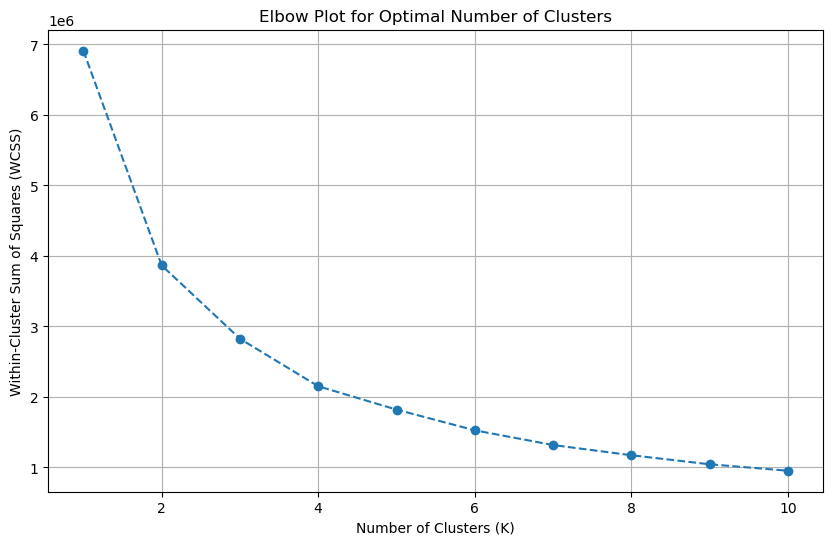

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_spotified_v3 = df_spotified_v2.copy()

# Filter out rows with 'Unknown' Year (Year == 0)
df_spotified_v3 = df_spotified_v3[df_spotified_v3['Year'] != 0]

# Cluster based on relevant features
features = ['BPM', 'Key', 'Runtime', 'Year',
            'Danceability', 'Energy', 'Acousticness', 'Instrumentalness',
            'Liveness', 'Valence', 'Speechiness']

X = df_spotified_v3[features].dropna()  # Drop rows with NaN values in the selected features

# Find optimal clusters using Elbow method 
wcss = []
K_range = range(1, 11)

for K in K_range:
    kmeans = KMeans(n_clusters=K, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

**K Means Clustering**

Again we conduct K Means clustering using the addtional Spotify attributes as well; however, upon inspecting the tracks in each cluster, there does not seem to be a very discernable pattern that explains why certain tracks fall within certain clusters. The only exception is Cluster 2, which seems to generally contain tracks which are purely instrumentals or otherwise have minimal lyrics (as evidenced by low Speechiness score).

Using the Spotify attributes for additional clustering does not seem to yield increasingly interesting clusters compared to the non-Spotify data, so we will take one last approach to analyzing the data.

In [44]:
# Select features for clustering
features = ['BPM', 'Key', 'Runtime', 'Year',
            'Danceability', 'Energy', 'Acousticness',
            'Instrumentalness', 'Liveness', 'Valence', 'Speechiness']

# Extract the subset of data for clustering
X = df_spotified_v3[features]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to df_spotified_v3
df_spotified_v3['Cluster'] = clusters

# Compute and print the cluster centers
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)

# Add cluster centers to df_spotified_v3
df_spotified_v3 = pd.concat([df_spotified_v3, cluster_centers], ignore_index=True)

# Print the first few rows of df_spotified_v3 with cluster centers added
df_spotified_v3 = df_spotified_v3[~df_spotified_v3['Name'].isna()].sort_values('Cluster', ascending = True)

/Users/fjohnson35/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


**Cluster 0**

In [45]:
df_spotified_v3[df_spotified_v3['Cluster']==0].head(15) 

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Danceability,Energy,Acousticness,Instrumentalness,Liveness,Valence,Speechiness,Cluster
352,71675593.0,Avalanche,Migos,126.00,11.0,205.0,Trap,2021.0,2020s,0.917,0.623,0.0985,0.000000,0.0833,0.687,0.1350,0.0
430,266450933.0,GATTI,"JACKBOYS, Pop Smoke & Travis Scott",71.57,19.0,182.0,Trap,2019.0,2010s,0.594,0.676,0.1350,0.000000,0.1630,0.472,0.3440,0.0
1024,85149603.0,SUNDOWN,Jack Harlow,92.00,3.0,104.0,Hip Hop,2020.0,2020s,0.816,0.754,0.1630,0.001990,0.1050,0.704,0.1520,0.0
1023,176009294.0,Nonstop,Drake,155.00,2.0,235.0,Hip Hop,2018.0,2010s,0.912,0.412,0.0165,0.012600,0.1040,0.423,0.1230,0.0
1022,114986956.0,Nonstop,Drake,155.00,2.0,238.0,Hip Hop,2018.0,2010s,0.912,0.412,0.0165,0.012600,0.1040,0.423,0.1230,0.0
1021,73643803.0,Never Recover,"Lil Baby, Gunna & Drake",132.00,9.0,221.0,Hip Hop,2018.0,2010s,0.753,0.686,0.0677,0.000000,0.1930,0.886,0.2840,0.0
435,186868144.0,Come Over,VanJess,101.00,9.0,222.0,NaN,2020.0,2020s,0.728,0.633,0.2750,0.001060,0.3490,0.560,0.2940,0.0
1020,115885629.0,Tribe,Bas & J. Cole,89.50,21.0,238.0,Hip Hop,2018.0,2010s,0.755,0.594,0.2410,0.000000,0.1070,0.237,0.2160,0.0
438,206935180.0,No Heart,21 Savage,140.00,21.0,235.0,NaN,2016.0,2010s,0.906,0.444,0.1360,0.000064,0.1730,0.678,0.3840,0.0
1018,124563315.0,Baby,Lil Baby & DaBaby,108.00,19.0,142.0,Hip Hop,2019.0,2010s,0.897,0.662,0.0852,0.000000,0.5340,0.390,0.2920,0.0


**Cluster 1**

In [46]:
df_spotified_v3[df_spotified_v3['Cluster']==1].head(15) 

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Danceability,Energy,Acousticness,Instrumentalness,Liveness,Valence,Speechiness,Cluster
1248,155236868.0,Baby $Hit,Freddie Gibbs & The Alchemist,130.00,5.0,216.0,Hip-Hop/Rap,2020.0,2020s,0.599,0.629,0.665000,0.016500,0.4470,0.5770,0.3810,1.0
1252,85058521.0,Girls Need Love,Summer Walker & Drake,97.00,3.0,222.0,R&B,2019.0,2010s,0.656,0.432,0.443000,0.000000,0.1320,0.0897,0.2170,1.0
1253,24341768.0,The F Bomb,EARTHGANG,130.00,24.0,240.0,Hip-Hop/Rap,2014.0,2010s,0.559,0.781,0.117000,0.000017,0.2760,0.1800,0.1320,1.0
856,96117551.0,The Weekend,SZA,102.00,9.0,206.0,Hip Hop x R&B,2017.0,2010s,0.400,0.366,0.242000,0.000000,0.1260,0.1610,0.0597,1.0
846,197761231.0,I Want You Around,Snoh Aalegra,84.00,9.0,213.0,R&B,2019.0,2010s,0.705,0.432,0.381000,0.133000,0.0841,0.5990,0.2050,1.0
1251,256588307.0,Needed Me,Rihanna,110.92,15.0,188.0,R&B,2016.0,2010s,0.697,0.315,0.110000,0.000000,0.0825,0.2980,0.2340,1.0
868,209717649.0,NOVACANE,FRANK OCEAN,93.50,9.0,325.0,hip hop x r&b,2011.0,2010s,0.762,0.508,0.058400,0.001260,0.1600,0.3700,0.0919,1.0
853,184620163.0,Perfect Timing,Nipsey Hussle,83.52,2.0,155.0,Hip Hop,2019.0,2010s,0.356,0.850,0.000552,0.000000,0.4470,0.1430,0.1060,1.0
875,113510880.0,Nobody,Keith Sweat feat Athena Cage,120.00,19.0,260.0,90's,1996.0,1990s,0.699,0.492,0.484000,0.000000,0.0482,0.3880,0.0318,1.0
872,175511098.0,Ready or Not,Fugees,178.00,11.0,216.0,90s x Golden Era,1996.0,1990s,0.544,0.428,0.245000,0.000000,0.0899,0.5240,0.5140,1.0


**Cluster 2**

In [47]:
df_spotified_v3[df_spotified_v3['Cluster']==2].head(15) 

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Danceability,Energy,Acousticness,Instrumentalness,Liveness,Valence,Speechiness,Cluster
294,50030295.0,Good Times,Chic,111.00,21.0,209.0,Funk x Disco,1979.0,1970s,0.869,0.503,0.081800,0.008370,0.1870,0.914,0.0479,2.0
306,116586599.0,Disturbia,Rihanna,125.00,1.0,276.0,Pop,2008.0,2000s,0.707,0.814,0.086100,0.000000,0.1680,0.717,0.0577,2.0
1037,255243886.0,I Wanna Be Down,Brandy,86.00,4.0,296.0,R&B,1995.0,1990s,0.703,0.469,0.177000,0.000000,0.7260,0.661,0.0415,2.0
1073,170762405.0,Because Of Love,Janet Jackson,112.00,16.0,262.0,R&B,1993.0,1990s,0.764,0.878,0.287000,0.003560,0.1800,0.825,0.0523,2.0
297,7387995.0,Uptown Funk,Mark Ronson Feat Bruno MArs,115.00,19.0,258.0,Boogie,2014.0,2010s,0.856,0.609,0.008010,0.000082,0.0344,0.928,0.0824,2.0
1114,148553023.0,Lost Ones,Lauryn Hill,94.84,19.0,257.0,Hip Hop,1998.0,1990s,0.832,0.749,0.099800,0.000004,0.0837,0.650,0.3700,2.0
373,263985026.0,Unforgettable,French Montana feat Swae Lee,98.00,7.0,313.0,Hip Hop x R&B,2017.0,2010s,0.749,0.784,0.071400,0.001020,0.1010,0.655,0.1710,2.0
1075,114643716.0,You Want This,Janet Jackson,112.00,16.0,305.0,R&B,1993.0,1990s,0.844,0.843,0.113000,0.043900,0.1000,0.647,0.0551,2.0
1115,254594485.0,93 'Til Infinity,Souls Of Mischief,103.00,13.0,284.0,Hip Hop,1993.0,1990s,0.590,0.672,0.125000,0.000001,0.1470,0.688,0.4120,2.0
1072,202860183.0,Runnin,The Pharcyde,94.00,15.0,300.0,Hip Hop,1996.0,1990s,0.754,0.785,0.028700,0.001440,0.3190,0.821,0.1800,2.0


**Cluster 3**

In [48]:
df_spotified_v3[df_spotified_v3['Cluster']==3].head(15) 

,TrackID,Name,Artist,BPM,Key,Runtime,Genre,Year,Decade,Danceability,Energy,Acousticness,Instrumentalness,Liveness,Valence,Speechiness,Cluster
1125,228462552.0,Love Lockdown,Kanye West,120.00,5.0,269.0,Pop,2008.0,2000s,0.760,0.524,0.054200,0.500,0.1120,0.1120,0.0323,3.0
910,154395295.0,Diggin' on You,TLC,79.97,10.0,250.0,90s,1994.0,1990s,0.719,0.631,0.023500,0.702,0.0686,0.4560,0.0451,3.0
23,142200919.0,Summer Madness,Kool & The Gang,87.16,5.0,257.0,Funk,1974.0,1970s,0.298,0.327,0.008340,0.860,0.0724,0.4540,0.0310,3.0
192,13022569.0,Pressing Groove,Fusion Funk Foundation & Lo Greco Bros,120.00,15.0,324.0,Jazz,2020.0,2020s,0.817,0.805,0.248000,0.745,0.1740,0.8090,0.0527,3.0
391,54186785.0,Rhythm Of The Night,Corona,128.00,15.0,212.0,afrobeat,2019.0,2010s,0.688,0.782,0.000235,0.666,0.0955,0.7700,0.0340,3.0
1294,126186995.0,Interstellar Main Theme,Patrik Pietschmann,100.54,23.0,284.0,Soundtrack,2019.0,2010s,0.578,0.194,0.991000,0.919,0.0545,0.0596,0.0381,3.0
476,162612405.0,HOT MUSIC,SOHO,112.09,17.0,305.0,House,2003.0,2000s,0.690,0.843,0.001210,0.686,0.2430,0.3460,0.0658,3.0
1148,165318185.0,Top Back (Instrumental),T.I.,80.00,17.0,291.0,Hip Hop,2006.0,2000s,0.695,0.138,0.993000,0.917,0.1100,0.3440,0.0605,3.0
482,185401150.0,Electric Relaxation (Instrumental),A Tribe Called Quest,98.03,9.0,228.0,Hip Hop,1993.0,1990s,0.937,0.449,0.028100,0.927,0.1770,0.9120,0.0837,3.0
191,146555460.0,Most of All,Fusion Funk Foundation & Lo Greco Bros,130.00,23.0,276.0,Jazz,2020.0,2020s,0.780,0.666,0.093000,0.909,0.1040,0.8290,0.0317,3.0


## **5) Clustering Using Principal Components**

Rather than clustering using the many features we now have for the data, we will utilize Principal Component analysis (PCA) in an attempt to only capture the most relevant information from the features and then cluster the tracks using this condensed information. PCA will account for any correlation between variables automatically and potentially yield further insights into track groupings.

### **5.1) Principal Component Analysis**

**PCA Definition**  

As defined in the 5/28 STA6704 lecture on Principal Component Analysis: 

_A principal component is a linear combination of the original features. Principal components are extracted in such a way that the first principal component explains the maximum variance in the dataset, the second principal component tries to explain the remaining variance in the dataset and is uncorrelated (orthogonal) to the first principal component, the third principal component tries to explain the remaining variance, which is not explained by the first two principal components and so on..._


**PCA Outcome**  

After performing PCA with 10 components, the resulting plot shows that no single component explain the majority of the variance in the data. The largest principal component only explains approximately 16% of the variance and 8 components are needed to explain more than 80% of the variance in the data. While this is less than the 11 features used to group the data in the original dataframe, it is not exactly a significant reduction in dimensionality.


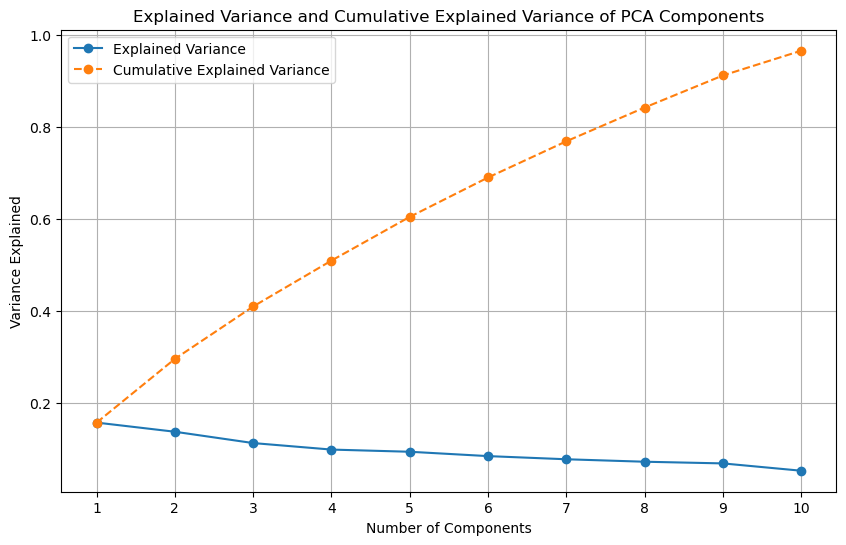

,TrackID,Name,Artist,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10
352,71675593.0,Avalanche,Migos,0.341483,-1.095722,-1.438163,0.493726,-0.433654,-0.099935,-0.329365,-0.148559,-0.029521,-0.791874
430,266450933.0,GATTI,"JACKBOYS, Pop Smoke & Travis Scott",-1.198335,-0.928636,0.680884,-1.258284,1.031216,0.662839,0.521297,0.793456,-0.309680,0.323259
1024,85149603.0,SUNDOWN,Jack Harlow,-0.131133,-1.481531,-0.905768,-0.328247,-1.281178,1.209902,1.078743,-0.523546,-0.716132,-0.160297
1023,176009294.0,Nonstop,Drake,-0.412575,-0.314375,-1.854071,1.829186,-1.269407,-1.585447,-0.138169,-0.215903,0.394381,-0.285504
1022,114986956.0,Nonstop,Drake,-0.401658,-0.296491,-1.839388,1.831347,-1.264763,-1.609205,-0.142688,-0.202188,0.395014,-0.309544
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,22817739.0,Horizon,Nujabes,2.867377,2.346598,0.700691,1.573408,0.130958,0.440492,2.900559,1.851378,0.373479,-2.101615
536,93458255.0,Percocet & Strippers Joint Dirty,Future,-1.445878,2.914813,-1.089190,0.197228,-0.039476,2.806353,2.888157,0.779967,1.874148,0.002576
885,103204990.0,Can't Truss It (Instrumental),Public Enemy,3.531726,0.996860,-0.317585,0.401461,-0.075135,0.722783,1.860617,0.176011,1.053495,-0.302265
136,217517148.0,Luchini (This Is It) (Instrumental),Camp Lo,2.234645,1.033019,0.681234,0.000426,-0.045986,1.038707,2.009227,-0.579584,0.536628,0.207166


In [49]:
from sklearn.decomposition import PCA
import numpy as np

df_spotified_v4 = df_spotified_v3.drop(columns=['Cluster'])

features = ['BPM', 'Key', 'Runtime', 'Year',
            'Danceability', 'Energy', 'Acousticness',
            'Instrumentalness', 'Liveness', 'Valence', 'Speechiness']

# Standardize inputs to PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_spotified_v3.drop(columns=['Cluster'])[features])

# Conduct PCA
pca = PCA(n_components=10)
principal_components = pca.fit_transform(scaled_features)

# Create DataFrame for PCA components
pca_columns = [f'PCA_Component_{i+1}' for i in range(10)]
df_pca_components = pd.DataFrame(principal_components, columns=pca_columns, index=df_spotified_v4.index)

# Concatenate PCA components with df_spotified_v3
df_spotified_v4 = pd.concat([df_spotified_v3.drop(columns=['Genre','Decade','Cluster']), df_pca_components], axis=1).drop(columns=features)

# Calculate explained variance and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create figure to plot both explained variance per component and cumulative variance
plt.figure(figsize=(10, 6))

# Plot explained variance
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-', label='Explained Variance')

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')

plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Explained Variance and Cumulative Explained Variance of PCA Components')
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid(True)
plt.show()

df_spotified_v4

### **5.2) K-Medoids Clustering Using 8 Principal Components**

**Elbow Method**  

We now conduct Clustering using the first 8 principle components of the data, which explain 80% of the variance. We use K-Medoids rather than K-Means this time to try a different approach that designates a specific track as a cluster's centroid. Using the Elbow method once again reveals that 4 clusters may be a good number of groupings in this case.

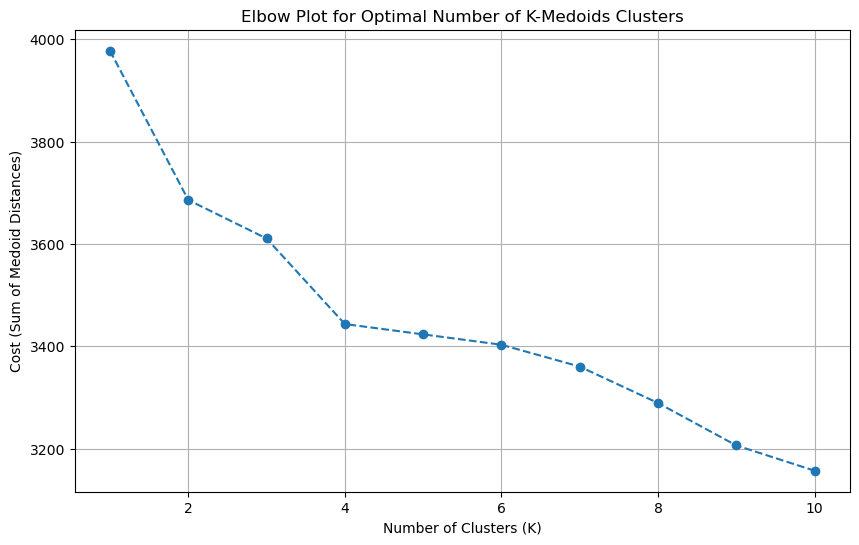

In [50]:
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

pca_features = [f'PCA_Component_{i+1}' for i in range(8)]

# Extract the subset of data for clustering
X_pca = df_spotified_v4[pca_features]

# Determine the optimal number of clusters using the elbow method
cost = []
K_range = range(1, 11)  

for K in K_range:
    kmedoids = KMedoids(n_clusters=K, random_state=0)
    kmedoids.fit(X_pca)
    cost.append(kmedoids.inertia_)  # Sum of distances to nearest medoid

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(K_range, cost, marker='o', linestyle='--')
plt.title('Elbow Plot for Optimal Number of K-Medoids Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost (Sum of Medoid Distances)')
plt.grid(True)
plt.show()

**K-Medoids Clustering**  

Clustering by the 8 PCA components using K-Medoids does yield different groupings, but no discernable pattern at first glance. An additional finding of interest for K-Medoids, however, is the centroid tracks for each cluster. These tracks can be thought of as representing the average combination of relevant features across all tracks in the cluster. 

In [51]:
# Select features for clustering
pca_features = [f'PCA_Component_{i+1}' for i in range(10)]

# Extract the subset of data for clustering
X_pca = df_spotified_v4[pca_features]

# Apply K-medoids clustering
kmedoids = KMedoids(n_clusters=4, random_state=0)
clusters = kmedoids.fit_predict(X_pca)

# Add cluster labels to df_spotified_v4
df_spotified_v4['Cluster_KMed'] = clusters


df_spotified_v4.sort_values('Cluster_KMed', ascending=True);

In [53]:
# Show Centroid Tracks
medoid_indices = kmedoids.medoid_indices_
centroids = df_spotified_v4.iloc[medoid_indices][['Name', 'Artist','Cluster_KMed']]


print('Centroid Tracks:')
centroids

Centroid Tracks:


,Name,Artist,Cluster_KMed
824,Broken Clocks,SZA,0
823,Coffee Bean,Travis Scott,1
1198,Heartless,Kanye West,2
415,Lavender,BadBadNotGood feat Kaytranada,3


**K-Medoid Cluster 0**

In [56]:
df_spotified_v4[df_spotified_v4['Cluster_KMed']==0]

,TrackID,Name,Artist,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,Cluster_KMed
1023,176009294.0,Nonstop,Drake,-0.412575,-0.314375,-1.854071,1.829186,-1.269407,-1.585447,-0.138169,-0.215903,0.394381,-0.285504,0
1022,114986956.0,Nonstop,Drake,-0.401658,-0.296491,-1.839388,1.831347,-1.264763,-1.609205,-0.142688,-0.202188,0.395014,-0.309544,0
1021,73643803.0,Never Recover,"Lil Baby, Gunna & Drake",0.549845,-1.192932,0.000683,0.459467,-1.068509,0.322680,-0.492954,0.643778,0.292866,-0.371791,0
435,186868144.0,Come Over,VanJess,-0.937846,-0.546515,0.749178,-0.270685,-0.629666,0.272224,0.040785,-0.005677,0.659372,-0.555808,0
1012,197305141.0,Mob Ties,Drake,-0.276037,-0.230807,-0.691835,2.813090,-1.570885,-0.370311,-0.462132,-0.569961,0.060366,0.075122,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
920,85820793.0,You Don't Know My Name (Instrumental),Alicia Keys,0.561422,3.227351,0.769123,0.447269,-0.038138,1.626713,2.718665,0.230345,1.244685,0.140694,0
182,75198042.0,Warm Floor,Fusion Funk Foundation & Lo Greco Bros,3.120393,1.456784,-0.648634,1.224275,1.565540,1.721587,1.478828,1.343832,1.600676,-1.993408,0
914,19537237.0,T-Shirt (Instrumental),Migos,2.261133,0.359282,-1.145092,2.305504,0.509942,1.612945,1.991860,1.677641,1.321891,-0.425606,0
363,22817739.0,Horizon,Nujabes,2.867377,2.346598,0.700691,1.573408,0.130958,0.440492,2.900559,1.851378,0.373479,-2.101615,0


**K-Medoid Cluster 1**

In [57]:
df_spotified_v4[df_spotified_v4['Cluster_KMed']==1]

,TrackID,Name,Artist,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,Cluster_KMed
352,71675593.0,Avalanche,Migos,0.341483,-1.095722,-1.438163,0.493726,-0.433654,-0.099935,-0.329365,-0.148559,-0.029521,-0.791874,1
1020,115885629.0,Tribe,Bas & J. Cole,-1.225721,-0.153717,-0.356459,-0.633517,1.439017,-0.340244,-0.151160,0.393649,-0.159246,-0.323480,1
438,206935180.0,No Heart,21 Savage,-0.224837,-1.201338,-0.973082,-0.137503,0.202271,-0.769681,-1.675627,0.765957,1.646906,-0.126360,1
1018,124563315.0,Baby,Lil Baby & DaBaby,-0.889271,-2.082976,0.573564,0.208603,0.757057,0.200233,-0.290184,-1.185410,1.506385,0.250703,1
1016,58232556.0,Blue Tint,Drake,-2.025939,-1.233082,-1.282552,1.050220,-1.212107,-1.717940,0.630468,0.165346,1.164676,0.856710,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,194927838.0,Way 2 Sexy (feat. Future & Young,Drake,1.046154,1.187390,-2.563123,1.571220,2.249458,0.393401,0.989332,0.725791,2.674167,-0.456487,1
566,10604667.0,CELL THERAPY (Instrumental),Goodie Mob,0.924253,2.201154,-1.622412,-0.387841,2.142731,-0.740817,1.951289,0.333683,1.531607,0.812842,1
919,245111137.0,Who Shot Ya (Instrumental),The Notorious B.I.G.,1.869747,1.405036,-1.378709,-0.094742,1.712973,-0.975434,1.670240,0.386687,1.591918,0.077632,1
887,139630510.0,Come Through & Chill (Instrumental),Miguel ft Salaam Remi & J. Cole,-0.313813,2.763770,-1.095784,0.904006,1.885016,-0.594455,2.627734,0.463638,1.231701,-0.523594,1


**K-Medoid Cluster 2**

In [58]:
df_spotified_v4[df_spotified_v4['Cluster_KMed']==2]

,TrackID,Name,Artist,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,Cluster_KMed
1017,62205163.0,T.D,Lil Yachty & Tierra Whack ft ASAP Rocky & Tyle...,-0.336275,-1.245905,1.550236,0.504787,-1.016611,0.114650,-0.562068,-0.535404,1.806300,-0.586747,2
1000,122408503.0,Kobe,Chief Keef,0.813605,-1.401981,0.157271,0.904995,-0.482139,0.106300,-0.647394,-0.143592,0.463165,-0.107337,2
999,175390932.0,D4L,"Future, Drake & Young Thug",0.421612,-0.725230,0.608756,0.090324,-0.650891,0.568004,1.099816,-1.314610,-0.599646,-0.841066,2
998,234483666.0,D4L,"Future, Drake & Young Thug",0.361930,-0.797645,0.544957,0.105193,-0.788220,0.658442,1.189126,-1.382453,-0.614785,-0.737222,2
464,147511164.0,Save Your Tears,The Weeknd,0.494796,-0.863835,1.426605,1.251115,1.442717,1.075981,-0.755524,-1.451212,-0.094985,-0.499927,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,124127738.0,The Next Episode feat. Snoop Dogg & Nate Dogg,Dr. Dre,3.535420,0.401124,-1.489374,0.483327,0.482676,2.016331,2.905361,0.325582,1.401762,0.180051,2
902,256902570.0,Ms. Jackson (Instrumental),Outkast,2.812674,1.253390,-1.604395,-0.220022,1.867844,0.695840,1.710125,0.653655,2.241674,-0.120876,2
916,126795382.0,The Choice Is Yours (Instrumental),Black Sheep,1.014985,1.948697,-1.061764,0.930080,0.093071,-0.673628,3.110958,0.389214,1.780786,1.151666,2
885,103204990.0,Can't Truss It (Instrumental),Public Enemy,3.531726,0.996860,-0.317585,0.401461,-0.075135,0.722783,1.860617,0.176011,1.053495,-0.302265,2


**K-Medoid Cluster 3**

In [59]:
df_spotified_v4[df_spotified_v4['Cluster_KMed']==3]

,TrackID,Name,Artist,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,PCA_Component_5,PCA_Component_6,PCA_Component_7,PCA_Component_8,PCA_Component_9,PCA_Component_10,Cluster_KMed
430,266450933.0,GATTI,"JACKBOYS, Pop Smoke & Travis Scott",-1.198335,-0.928636,0.680884,-1.258284,1.031216,0.662839,0.521297,0.793456,-0.309680,0.323259,3
1024,85149603.0,SUNDOWN,Jack Harlow,-0.131133,-1.481531,-0.905768,-0.328247,-1.281178,1.209902,1.078743,-0.523546,-0.716132,-0.160297,3
413,35424394.0,Lavender,BadBadNotGood feat. Kaytranada & Snoop Dogg,-0.257512,-0.589250,-0.172015,0.069988,-0.182867,0.172725,0.697657,0.387197,-0.892533,0.069753,3
415,155325448.0,Lavender,BadBadNotGood feat Kaytranada,-0.258828,-0.589318,-0.168867,0.057461,-0.179069,0.172614,0.707195,0.383989,-0.895381,0.067034,3
1029,133438336.0,Yessirskiii,Lil Uzi Vert & 21 Savage,0.714156,-1.779784,-0.721628,0.864630,-1.157919,-0.156430,-0.310814,0.833001,0.261213,-0.573484,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,234583861.0,Back on the Block,Orange Factory,1.684888,1.989307,-0.398997,0.476709,-0.291867,1.412152,2.226429,1.020895,0.562596,-0.735677,3
440,47332215.0,Dragonball Durag,Thundercat,-0.969480,2.668568,-1.264712,-0.263195,-0.536182,2.569832,2.508571,0.431481,1.480914,-0.730208,3
908,218405747.0,Shake It Off (Instrumental),Mariah Carey,1.403558,1.452365,-0.453314,0.875617,-1.063895,1.446088,1.922859,2.625898,2.168714,1.167979,3
845,234112267.0,UFO,ESG,0.146930,1.757965,-1.386993,0.605528,2.239176,1.861986,2.275756,0.409481,1.446798,4.426251,3


In [60]:
# Define features for PCA
features = ['BPM', 'Key', 'Runtime', 'Year',
            'Danceability', 'Energy', 'Acousticness',
            'Instrumentalness', 'Liveness', 'Valence', 'Speechiness']

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_spotified_v3.drop(columns=['Cluster'])[features])

# Apply PCA
pca = PCA(n_components=2)  # Specify the number of components
principal_components = pca.fit_transform(scaled_features)

# Create DataFrame for PCA components
pca_columns = ['PCA_Component_1', 'PCA_Component_2']
df_pca_components = pd.DataFrame(principal_components, columns=pca_columns, index=df_spotified_v4.index)

# Concatenate PCA components with df_spotified_v3
df_spotified_v5 = pd.concat([df_spotified_v3.drop(columns=['Genre','Decade','Cluster']), df_pca_components], axis=1).drop(columns=features)


df_spotified_v5

,TrackID,Name,Artist,PCA_Component_1,PCA_Component_2
352,71675593.0,Avalanche,Migos,0.341483,-1.095722
430,266450933.0,GATTI,"JACKBOYS, Pop Smoke & Travis Scott",-1.198335,-0.928636
1024,85149603.0,SUNDOWN,Jack Harlow,-0.131133,-1.481531
1023,176009294.0,Nonstop,Drake,-0.412575,-0.314375
1022,114986956.0,Nonstop,Drake,-0.401658,-0.296491
...,...,...,...,...,...
363,22817739.0,Horizon,Nujabes,2.867377,2.346598
536,93458255.0,Percocet & Strippers Joint Dirty,Future,-1.445878,2.914813
885,103204990.0,Can't Truss It (Instrumental),Public Enemy,3.531726,0.996860
136,217517148.0,Luchini (This Is It) (Instrumental),Camp Lo,2.234645,1.033019


### **5.3) Visualizing K-Medoids Clustering Using 2 Principal Components**

Despite the fact that multiple principal components are needed to yield "statistically relevant" clustering results (i.e. clustering that explains an adequate amount of data variance), visualizing clustering algorithm outcomes is often one of the draws of K-Means / K-Medoids clustering and is still useful here. 

Since PCA and clustering are not necessarily supervised learning techniques where a correct target / answer exists, we can employ them in many different manners without genering "wrong answers". We will lastly experiment with visualizing K-Medoid clustering using only the first 2 principal components. Plotting the K-Medoids clusters along the first principal component axes identifies the centroid track of each cluster as well as one other randomly selected track within each cluster.

Cluster Centers in PCA Space:
[[ 0.23911743 -0.91294291]
 [-1.34924116  1.5822365 ]
 [-1.00402949 -0.29077323]
 [ 1.45582755  0.43518444]]
Centroid Track Names:
368      Back To The Streets
553            Rum & Redbull
1094                  OOOUUU
743     U Don't Have To Call
Name: Name, dtype: object


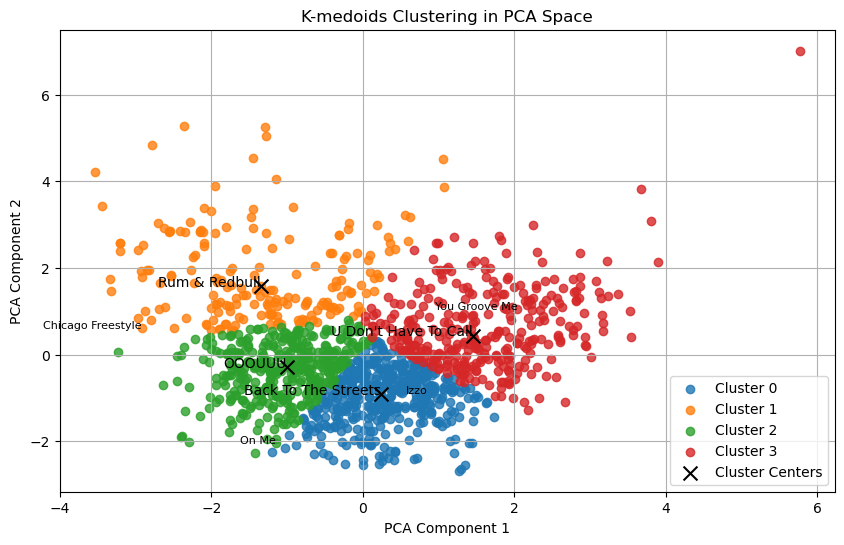

In [80]:

# Extract the first 2 principal components
pca_2_components = principal_components[:, :2]

# Apply K-medoids clustering
k = 4  # Number of clusters
kmedoids = KMedoids(n_clusters=k, random_state=42)
clusters = kmedoids.fit_predict(pca_2_components)

# Add cluster labels to df_spotified_v4
df_spotified_v4['Cluster'] = clusters

# Print the cluster centers in PCA space
cluster_centers_indices = kmedoids.medoid_indices_
cluster_centers_pca = pca_2_components[cluster_centers_indices]

# Get names of centroid tracks
centroid_names = df_spotified_v4.iloc[cluster_centers_indices]['Name']

print("Cluster Centers in PCA Space:")
print(cluster_centers_pca)
print("Centroid Track Names:")
print(centroid_names)

# Plot the clusters in PCA space
plt.figure(figsize=(10, 6))
for cluster_label in range(k):
    plt.scatter(pca_2_components[clusters == cluster_label, 0], 
                pca_2_components[clusters == cluster_label, 1], 
                label=f'Cluster {cluster_label}', alpha=0.8)
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], marker='x', color='black', s=100, label='Cluster Centers')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-medoids Clustering in PCA Space')

# Annotate centroid tracks and two random tracks per cluster
for i, txt in enumerate(centroid_names):
    plt.annotate(txt, (cluster_centers_pca[i, 0], cluster_centers_pca[i, 1]), fontsize=10, ha='right', color='black')
    
    # Get tracks in the current cluster
    cluster_tracks = df_spotified_v4[df_spotified_v4['Cluster'] == i]
    
    # Randomly select / display 1 more track for each cluster
    if len(cluster_tracks) > 2:
        random_tracks = cluster_tracks.sample(1, random_state=46)
    else:
        random_tracks = cluster_tracks
    
    for _, track in random_tracks.iterrows():
        plt.annotate(track['Name'], 
                     (pca_2_components[df_spotified_v4.index == track.name, 0], 
                      pca_2_components[df_spotified_v4.index == track.name, 1]), 
                     fontsize=8, ha='right', alpha=1)

plt.legend()
plt.grid(True)
plt.show()

## **6) Conclusion**

DJing, like most artistic forms, is a difficult subject to objectively analyze. Waveforms, tempo, and track length are just a few of the attributes we can review for tracks to gain further insights; however, often metadata alone cannot fully describe a musical composition. This is evidenced by some of the analysis of this project. While unsupervised learnings affords us the ability to examine tracks without needing to label findings as right or wrong, it also can result in ambiguity that is uninterpretable. 

This is also seen in some of the data insights derived from Spotify when the characteristics of a song that are described by specific attributes contradict the values of those very attributes. For instance, many tracks in the library, while obviously joyous in tone when listened to, have very low valence values that imply these same tracks are not cheerful at all. Conversely, many tracks that exude negative emotions such as fear or anger have high valence values that denote positive moods. Many other examples exist for other features. That said, these attributes do accurately describe other tracks and as a whole provide new dimensions from which to view the data.

Overall, the statistical and machine learning techniques used for analyzing this music library help to shape my understanding of the data at some level, albeit in an abstract manner. Additional data cleaning, feature engineering, and creative modeling solutions will surely yield even more interesting results.